In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from collections import defaultdict
from shapely import speedups
from shapely.geometry import Polygon,Point,mapping
speedups.enable()

In [2]:
# Another good one. I went for shapely to handle the triangles but 
# the gain I get from optimised code is offset by that code being
# very general. I wrote my own area function to speed up the triangle finding
# copying and pasting stackexchange code for the polygon intersections will
# probably speed up immensely
# I managed to swap x & y coordinates round early on and bug fixed until it's
# all consistent! One to fix on a very dull day.

url='https://www.janestreet.com/puzzles/tri-tri-again-again/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:19]))

Description Place a collection of right triangles into the grid below. The triangles must have integer-length legs, and the legs must be along grid lines. Each triangle must contain exactly one number. That number represents the area of the triangle containing it. (Every number must eventually be contained in exactly one triangle.) The entire square (1-by-1 cell) containing the number must be inside the triangle. Triangles’ interiors may not overlap. (But triangles’ boundaries may intersect, as seen in the example.) As your answer to this month’s puzzle, please send in the product of the odd horizontal leg lengths.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/10/20191002_tri_again.png" width="350" >

In [3]:
# set up the groups
grid = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  2,  0,  0, 0],
                 [ 0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0, 0],
                 [ 4,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0, 0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 5],
                 [ 0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0, 10,  0,  0, 0],
                 [ 0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0],
                 [ 0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0, 3],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0, 0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0],
                 [ 4,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18, 0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0, 0],
                 [ 0,  0,  0,  9,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0, 0],
                 [ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0],
                 [ 0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0, 6],
                 [ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0, 0],
                 [ 0,  0,  0,  2,  0,  0,  0, 18,  0,  0,  0,  0,  0,  0,  0,  0, 0]
                ],dtype =int)

In [4]:
class Matrix():
    def __init__(self,grid,tris=[]):
        self.tris = tris
        self.grid = grid
        # have a grid of labeled points and 
        # numbers representing each one
        self.grid_points = dcopy(grid)
        self.numbers = self.grid_points[self.grid_points!=0] # the number 
        labels = np.arange(np.sum(self.grid_points!= 0))
        # store the status of each placed triangle
        self.placed = np.zeros(np.sum(self.grid_points!= 0))
        # label each number and store the number 
        # fiddle around to have the points numbered from 0-28        
        self.grid_points[self.grid_points==0] = -1
        self.grid_points[self.grid_points!=-1] = labels 
        self.end_flag = 0

        
    ################
    # run through the grid determining which triangles are possible for each number
    def possible_triangles(self):
        triangle_dict = defaultdict(list)
            # loop throught all the cells create every triangle then
            # check the cells to see which numbers are fully in the 
            # triangle if there are any check check the area is correct 
            # and there is only one touching the triangle 
            # touching condition important. Will solve without but
            # Takes 4 hours due to increased number of possibilities
        for row,col in itertools.product(range(18),range(18)):
            for h,v in itertools.product(range(18),range(18)):
                area =self.area(row,col,h,v)
                if area not in self.numbers:
                    continue
                triangle = Polygon([[row,col],[h,col],[row,v]])
                cells = self.cells_in_area(triangle)                
                labels_in_cell = self.grid_points[cells == 1]
                label = labels_in_cell[labels_in_cell != -1]
                if len(label) ==1:
                    if area == self.numbers[label[0]]:
                        check_cell = self.cells_touching_area(triangle)
                        # touching does not include contains so need an or here
                        labels_touching_cell = self.grid_points[(check_cell == 1) | (cells == 1)]
                        if np.any(labels_touching_cell ==label) ==1:                       
                            triangle_dict[label[0]].append(triangle)
                
        return triangle_dict 
    
    # simple area for a right triangle, quicker than using shapely
    def area(self,row,col,h,v):
        return 0.5 * abs(row-h)*abs(col-v)
    
    # find cells fully in each triangle. Forming a square round each cell 
    # and checking intersection
    def cells_in_area(self,triangle):
        coords = np.array(mapping(triangle)['coordinates'])[0,:-1,:]
        row_min = int(np.min(coords[:,0]))
        row_max = int(np.max(coords[:,0]))
        col_min = int(np.min(coords[:,1]))
        col_max = int(np.max(coords[:,1]))
        cells = np.zeros((17,17))
        for i in range(row_min,row_max):
            for j in range(col_min,col_max):
                cell =Polygon([[i,j],[i+1,j],[i,j+1],[i+1,j+1]])
                cells[i,j] = cell.within(triangle.buffer(1e-14))
        return cells
    
    #find cells partially (but not fully .. that took a while to find) in each triangle
    # as above forming a square and checking intersection
    def cells_touching_area(self,triangle):
        coords = np.array(mapping(triangle)['coordinates'])[0,:-1,:]
        row_min = int(np.min(coords[:,0]))
        row_max = int(np.max(coords[:,0]))
        col_min = int(np.min(coords[:,1]))
        col_max = int(np.max(coords[:,1]))
        cells = np.zeros((17,17))
        for i in range(row_min,row_max):
            for j in range(col_min,col_max):
                cell =Polygon([[i,j],[i+1,j],[i,j+1],[i+1,j+1]])
                cells[i,j] = cell.overlaps(triangle.buffer(-1e-14))
        return cells
    
    ########################################################
    # Backtracking loop through the triangle placements until
    # they all fit. As usual, solving in the obvious order is slow
    def place_tris(self):
        if self.end_flag == 0:
            for label in range(28,-1,-1):
                if self.placed[label] == 0:
                    if len(self.poss_tris[label]) > 0:                
                        for tri in self.poss_tris[label]:
                            if self.possible(tri):
                                self.tris.append(tri)
                                self.placed[label] = 1
                                self.place_tris()
                                self.tris.remove(tri)
                                self.placed[label] = 0
                        return
            self.end_flag=1
            output = [np.array(mapping(x)['coordinates'])[0,:-1,:] for x in self.tris]
            self.lengths(output)
            grid_print(self.grid,output)
            
    # Check that the triangles doesn't intersect any of the placed triangles
    def possible(self,tri):
        if len(self.tris) == 0:
            return True
        for placed_tri in self.tris:
            if tri.overlaps(placed_tri):
                return False
        return True
                            
    # work out the product of the odd horizontal leg lengths the solution
    def lengths(self,tris):
        lengths = []

        for tri in tris:
            [x0,y0],[x1,y1],[x2,y2] = tri
            length = abs(y1-y2)
            if length % 2 == 1: 
                lengths.append(length)
        print("The product of the odd horizontal leg lengths = {:,.0f}".format(np.prod(lengths)))            
        
    # main loop to pull it all together
    # find the possible triangles and then send to solve
    # to place
    def solve(self):
        start = time.perf_counter()
        print("Finding all triangles ...")
        poss_tris = self.possible_triangles()
        mid =  time.perf_counter()
        print('All possible triangles found after {:0.2f} seconds'.format((mid-start)))
        print("Number of points picked :",len(poss_tris))
        print('Number of possible placements for each point:',{key:len(poss_tris[key]) for key in poss_tris})
        print("\nPlacing triangles ...")
        self.poss_tris = poss_tris
        self.place_tris()
        end =  time.perf_counter()
        print("Placing triangles took {:0.2f} seconds".format(end-mid))
        
#############################    
# print out the result nicely    
def grid_print(grid,tris):        
        fig,ax = plt.subplots(1,1,figsize=(5,5))
        x = np.array((grid).astype('int').astype('str'))
        x[x=="0"] =""
        y = grid !=0
        ax = sns.heatmap(y,annot=x,cbar=False,cmap="Reds",center =2,fmt="",linewidths=1,linecolor="lightgrey")
        ax.axis("off")
        for tri in tris:
            for points in itertools.combinations(tri,2):
                plt.plot([points[0][1],points[1][1]],[points[0][0],points[1][0]], linewidth=1,color="b")
        plt.tight_layout()       
        

Finding all triangles ...
All possible triangles found after 79.57 seconds
Number of points picked : 29
Number of possible placements for each point: {2: 39, 5: 44, 0: 16, 1: 2, 3: 10, 4: 5, 9: 50, 8: 20, 14: 152, 6: 8, 7: 5, 17: 26, 11: 16, 10: 8, 16: 71, 12: 8, 13: 4, 18: 31, 15: 6, 19: 47, 21: 14, 20: 22, 24: 12, 22: 8, 23: 16, 25: 21, 26: 12, 27: 2, 28: 23}

Placing triangles ...
The product of the odd horizontal leg lengths = 31,185
Placing triangles took 186.24 seconds

Solved Grid
~~~~~~~~~~~


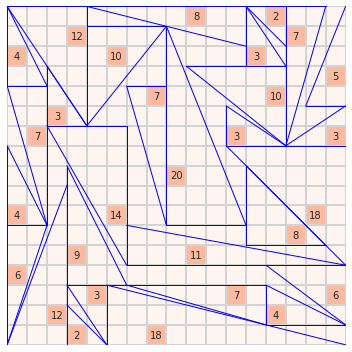

In [5]:
test = Matrix(grid)
test.solve()
print('\nSolved Grid')
print('~~~~~~~~~~~')

In [6]:
url='https://www.janestreet.com/puzzles/solutions/october-2019-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The answer to this month’s puzzle is 31185 , and the completed grid is presented here.  Congratulations to everyone who got the correct answer this month!


### Puzzle solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/11/Oct19_Solution.png" width="350" >

In [7]:
# ************* Bug finding code that I'll keep for when I improve this ***********************************

test_triangles  =  [[[0, 14], [0, 12], [2, 14]], [[0, 14], [0, 16], [7, 14]], [[5, 17], [5, 15], [0, 17]],
                    [[7, 17], [7, 14], [5, 17]], [[7, 17], [7, 11], [13, 17]], [[3, 14], [3, 9], [7, 14]],
                    [[3, 12], [3, 14], [0, 12]],[[7, 11], [7, 14], [5, 11]], [[17, 3], [17, 0], [9, 3]],
                    [[11, 0], [11, 2], [7, 0]], [[11, 0], [11, 2], [17, 0]], [[17, 3], [17, 5], [15, 3]],
                    [[4, 2], [4, 0], [11, 2]], [[4, 0], [4, 2], [0, 0]], [[0, 4], [0, 0], [6, 4]],
                    [[6, 2], [6, 4], [3, 2]], [[0, 12], [0, 4], [2, 12]], [[1, 4], [1, 8], [6, 4]],
                    [[4, 8], [4, 6], [11, 8]], [[11, 8], [11, 12], [1, 8]], [[6, 6], [6, 2], [13, 6]],
                    [[14, 3], [14, 6], [8, 3]],[[13, 6], [13, 17], [11, 6]], [[12, 12], [12, 16], [8, 12]],
                    [[14, 5], [14, 3], [17, 5]], [[17, 5], [17, 17], [14, 5]], [[14, 13], [14, 6], [16, 13]], 
                    [[16, 13], [16, 17], [14, 13]], [[13, 17], [13, 13], [16, 17]]]

obj_tris = []

for tri in test_triangles:
    obj_tris.append(Polygon(tri)) 

In [8]:
 def cells_touching_area(triangle):
        coords = np.array(mapping(triangle)['coordinates'])[0,:-1,:]
        row_min = int(np.min(coords[:,0]))
        row_max = int(np.max(coords[:,0]))
        col_min = int(np.min(coords[:,1]))
        col_max = int(np.max(coords[:,1]))
        cells = np.zeros((17,17))
        for i in range(row_min,row_max):
            for j in range(col_min,col_max):
                cell =Polygon([[i,j],[i+1,j],[i,j+1],[i+1,j+1]])
                cells[i,j] = cell.overlaps(triangle.buffer(-1e-14))
        return cells
    
def cells_in_area(triangle):
        coords = np.array(mapping(triangle)['coordinates'])[0,:-1,:]
        row_min = int(np.min(coords[:,0]))
        row_max = int(np.max(coords[:,0]))
        col_min = int(np.min(coords[:,1]))
        col_max = int(np.max(coords[:,1]))
        cells = np.zeros((17,17))
        for i in range(row_min,row_max):
            for j in range(col_min,col_max):
                cell =Polygon([[i,j],[i+1,j],[i,j+1],[i+1,j+1]])
                cells[i,j] = cell.within(triangle.buffer(1e-14))
        return cells

In [10]:
for t in obj_tris:
    x= cells_touching_area(t)
    y = cells_in_area(t)
    #print(grid[x==1],grid[(y==1) | (x==1)])

    #grid_print(x,[np.array(mapping(t)['coordinates'])[0,:-1,:]])